In [17]:
import pandas as pd
import numpy as np
import json
from datetime import date

from plotnine import *
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import sys

from utils import *

df = pd.read_csv('./data/VinIDRecruitChallenge_MLTrack_DataSet.csv')

# cleaning data

In [3]:
df = clean_data(df)
    

# Visualization

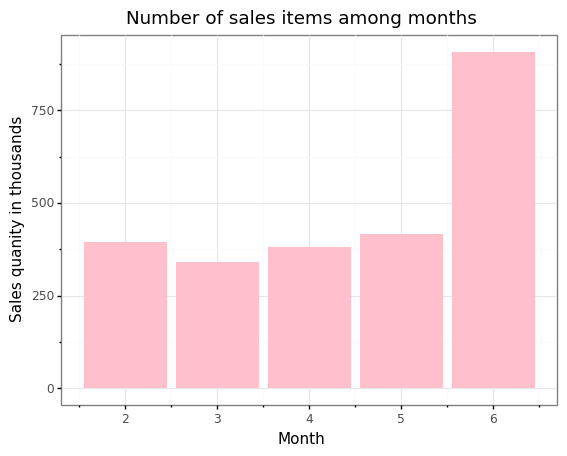

<ggplot: (321025517)>

In [4]:
# sales quantity : number of items
df_month= df.groupby(['month'])[ 'salesquantity'].sum().reset_index()
df_month['salesquantity'] = df_month['salesquantity']/ 1000                                                                                  

(ggplot(df_month,
    aes('month', 'salesquantity'))+
    geom_col(fill = 'pink')+
    theme_bw() +
    xlab('Month')+
     ylab('Sales quanity in thousands') +
    ggtitle('Number of sales items among months'))



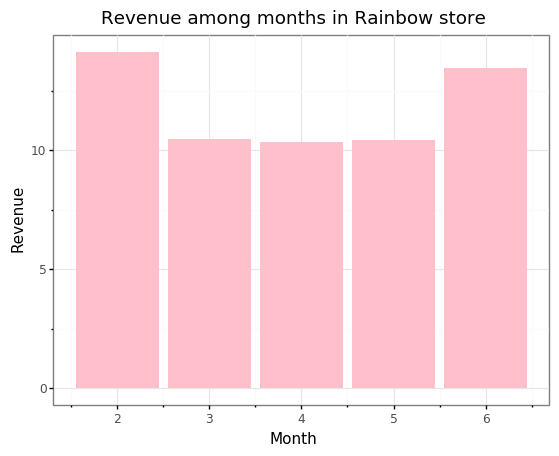

<ggplot: (320986433)>

In [5]:
df_month= df.groupby(['month'])[ 'revenue'].sum().reset_index()
df_month['revenue'] =  df_month['revenue']/1000000000  

(ggplot(df_month,
       aes('month', 'revenue'))+
    geom_col(fill = 'pink')+
    theme_bw() +
    xlab('Month')+
     ylab('Revenue') +
    ggtitle('Revenue among months in Rainbow store'))

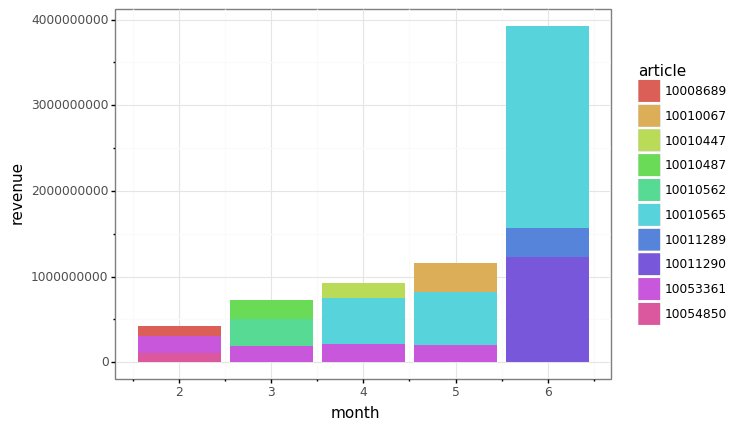

<ggplot: (320894113)>

In [6]:
# products that are bough often
df_month= df.groupby(['month', 'article'])[ 'revenue'].sum().reset_index().sort_values(by='revenue', ascending=False)
df_month=df_month.groupby(['month']).head(3)

(ggplot(df_month, 
      aes('month', 'revenue',fill='article'))+
geom_bar(stat="identity")+
theme_bw())


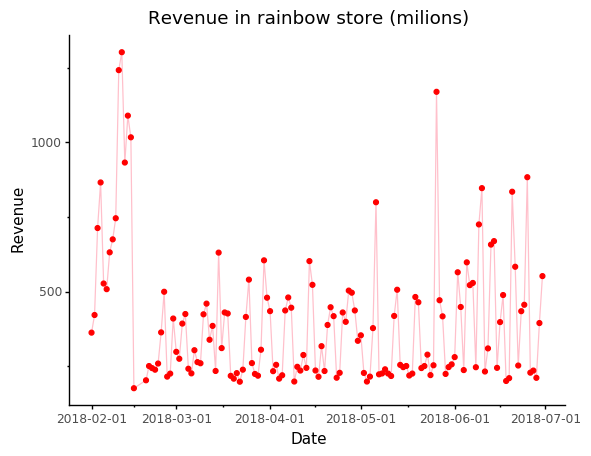

<ggplot: (320698989)>

In [7]:
# number of sales 
df_sum=df.groupby('date')['revenue'].sum().reset_index()
df_sum['revenue'] = df_sum['revenue'] /1000000

(ggplot(df_sum, 
      aes('date', 'revenue'))+
    geom_line(color='pink')+
    geom_point(color='red')+
    theme_classic()+
    xlab('Date')+
     ylab('Revenue') +
    ggtitle('Revenue in rainbow store (milions)')) 

# Model engineering

In [8]:
mydf = get_data_modelling(df)

mydf['recency']= mydf['recency'].map(lambda x: x.days)
mydf = mydf.drop_duplicates()

Month processed: 2
Month processed: 3
Month processed: 4


# Model selections

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = mydf.loc[:, ['frequency','moneytary','recency', 'month_examined']]
y = mydf['buy_next_month']
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=42)


======== Training models done ========


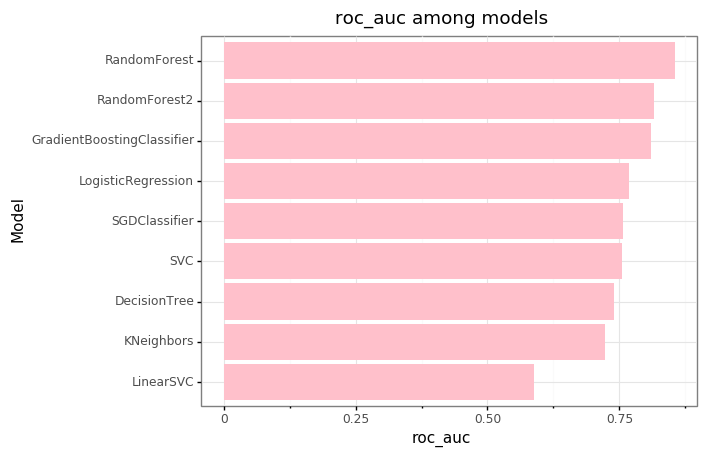

<ggplot: (321025333)>


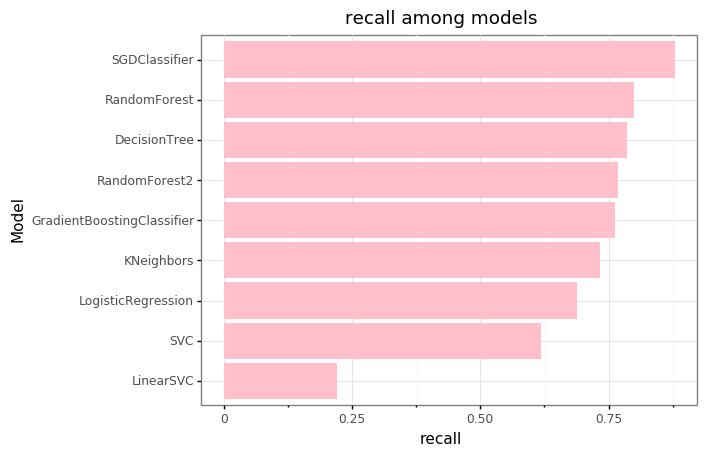

<ggplot: (321004045)>


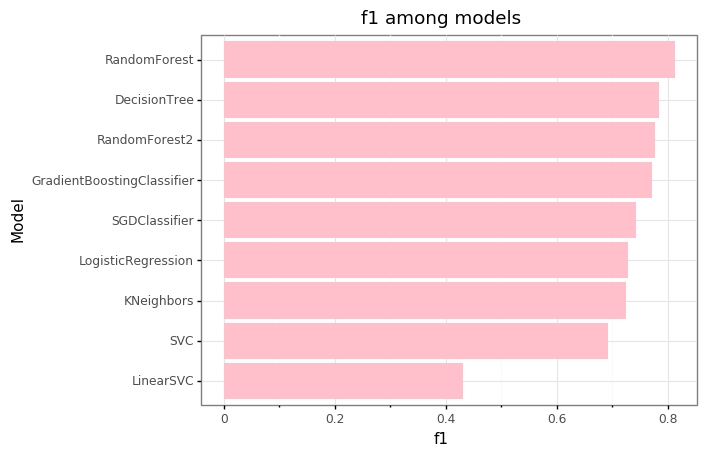

<ggplot: (321060805)>


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.model_selection import cross_val_score

models = []

models.append(('LogisticRegression', LogisticRegression()))
models.append(("SGDClassifier",SGDClassifier(random_state=0)))
models.append(("SVC",SVC()))
models.append(("LinearSVC",LinearSVC()))
models.append(("KNeighbors",KNeighborsClassifier()))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
rf2 = RandomForestClassifier(n_estimators=100, criterion='gini',
                             max_depth=10, random_state=0, max_features=None)
models.append(("RandomForest2",rf2))
models.append(("GradientBoostingClassifier", GradientBoostingClassifier()))


results = {}
names = []
cv = 3
for name,model in models:
    result = {'accuracy' :cross_val_score(model, X_train, y_train,  cv=cv, scoring='accuracy').mean()}
    result.update({'precision':cross_val_score(model, X_train, y_train,  cv=cv, scoring='precision').mean()})
    result.update({'recall':cross_val_score(model, X_train, y_train,  cv=cv, scoring='recall').mean()})
    result.update({'f1':cross_val_score(model, X_train, y_train,  cv=cv, scoring='f1').mean()})
    result.update({'roc_auc':cross_val_score(model, X_train, y_train,  cv=cv, scoring='roc_auc').mean()})
    results.update({name: result})

print('======== Training models done ========')

df_result = pd.DataFrame(results).sort_values( by= ['recall', 'roc_auc', 'f1'], axis=1, ascending=False).T
df_result = df_result.reset_index().rename(columns={'index':'model'})

for col in ['roc_auc', 'recall', 'f1']:
    plot_bar(df_result, col)

Since the business question is how to find the most likely purchased customers in the next month, we have to train a classifier that find the most likely purchased customers. 

Therefore, we will prioritize the models which has the highest recall due to the fact that we wan to find the likely buying customers as many as possible (although the marketing team will get a few false casees, almost all buying customers will be reached out).

Based on the cross validation scores, Random forests will be our 1st candidates. We will dig deeper into it in order to optimise this model.


# Final model

In [11]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

rf = RandomForestClassifier()
param_grid = {
    #'bootstrap': [True, False],
    #'max_depth': [80, 90, 100, 110],
    #'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300],
}
gridF = GridSearchCV(rf, param_grid, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

from sklearn.model_selection import cross_val_predict
print('Best score in CV is: {bestF.best_score_}')

model = bestF.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   11.4s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   17.8s finished


Best score in CV is: {bestF.best_score_}


# Predictions on test set:



In [14]:
y_pred = model.predict(X_test)

from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score,roc_curve

for k, v in {'precision_score':precision_score, 'recall_score':recall_score, 
               'roc_auc_score':roc_auc_score, 'f1_score':f1_score}.items():
    print(k, v(y_test, y_pred))


precision_score 0.8735446313065977
recall_score 0.8367410161090458
roc_auc_score 0.8327750614695842
f1_score 0.8547468354430379


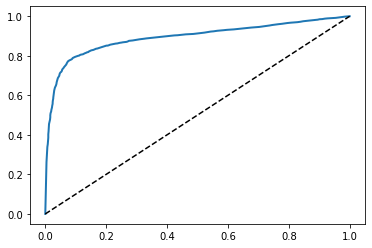

In [20]:
y_score= model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

    
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal 
    [...] # Add axis labels and grid 
        
plot_roc_curve(fpr, tpr)    

# What customers purchase next month?

In [21]:
selected_feat = X_test.columns
mydf['y_pred'] = model.predict(mydf[selected_feat])

# merge df to get customer numbers
final_df = X_test.merge(mydf, how='left').drop('month',axis=1).drop_duplicates()
final_df = final_df.sort_values(by='month_examined')

final_df['y_pred'] = le.inverse_transform(final_df['y_pred'])
final_df.to_csv('./data/prediction.csv')

print('Write predictiin file is Done!')


Write predictiin file is Done!


# Discussion
There are 2 potential problems that needs to take into consideration:
    - Since the model does not take into account what type of products that a given customer likely to buy, the marketting team might have to widen their product categories when sending out the campaign, or focus on the best-seller products.
    - Random forest is not opitmized based on the search hyper-parameters. The performance of the model could be improved more if if was optimized.
    